# Variants

In [1]:
from __future__ import annotations

from bitarray import bitarray
import Bio.Seq

class CoreBitMask:
    
    def __init__(self, sequence: Bio.Seq.Seq = None, existing_bitmask: bitarray = None):
        if existing_bitmask is not None and sequence is not None:
            raise Exception(f'Cannot set both existing_bitmask={existing_bitmask} and sequence={sequence}')
            
        if existing_bitmask:
            self._core_bitmask = existing_bitmask
        elif sequence:
            self._core_bitmask = bitarray(len(sequence))
            self._core_bitmask.setall(True)
            self._add_sequence(sequence)
        else:
            raise Exception('If no existing_bitmask set then sequence must be defined')
            
    def append_bitmask(self, bitmask: CoreBitMask) -> CoreBitMask:
        if bitmask is None:
            return self
        else:
            combined_array = self._core_bitmask & bitmask._core_bitmask
            return CoreBitMask(existing_bitmask=combined_array)
            
    def _add_sequence(self, sequence: Bio.Seq.Seq) -> float:
        for idx, char in enumerate(sequence):
            if char.upper() == 'N' or char == '-':
                self._core_bitmask[idx] = False
                
    def get_bytes(self):
        return self._core_bitmask.tobytes()
    
    def core_length(self) -> int:
        return self._core_bitmask.count()
    
    def core_proportion(self) -> float:
        return self.core_length()/len(self)
    
    def __len__(self) -> int:
        return len(self._core_bitmask)
    
    def __getitem__(self, index: int) -> bool:
        return self._core_bitmask[index]
    
s = Bio.Seq.Seq('ATCG-NN')
mask = CoreBitMask(sequence=s)
mask.core_proportion()

0.5714285714285714

In [2]:
from typing import List, Dict
import vcf
import Bio.Seq
from Bio import SeqIO
import pandas as pd
import re
import os

class VariantsReader:
    
    def __init__(self):
        pass

    def read_vcf(self, file: str) -> pd.DataFrame:
        reader = vcf.Reader(open(file, 'r'))
        df = pd.DataFrame([vars(r) for r in reader])
        out = df.merge(pd.DataFrame(df.INFO.tolist()),
                       left_index=True, right_index=True)
        out = out[['CHROM', 'POS', 'REF', 'ALT', 'DP', 'QUAL', 'RO', 'AO', 'INFO']]
        out['TYPE'] = out['INFO'].map(lambda x: x['TYPE'][0])
        out = out.drop('INFO', axis='columns')
        out['ALT'] = out['ALT'].map(lambda x: str(x[0]))
        out['REF'] = out['REF'].map(lambda x: str(x[0]))
        out['AO'] = out['AO'].map(lambda x: x[0])
        cols = out.columns.tolist()
        out['FILE'] = os.path.basename(file)
        out = out.reindex(columns=['FILE'] + cols)
        return out

    def read_vcfs(self, files: List[str]) -> pd.DataFrame:
        frames = [self.read_vcf(f) for f in files]
        return pd.concat(frames)
    
    def read_core_masks(self, bit_mask_files_dir: str) -> Dict[str, Dict[str, CoreBitMask]]:
        files = [os.path.join(bit_mask_files_dir, f) for f in os.listdir(bit_mask_files_dir) if f.endswith('.fa')]
        core_masks = {}
        for file in files:
            name = re.sub('\.aligned\.fa$', '', os.path.basename(file))
            core_masks[name] = {}
            for record in SeqIO.parse(file, 'fasta'):
                if record.id not in core_masks[name]:
                    core_masks[name][record.id] = CoreBitMask(sequence=record.seq)
                    print(f'{name}:{record.id} -> {core_masks[name][record.id].core_proportion()}')
                    
        return core_masks

directory = 'data/snps-vcf'
files = [os.path.join(directory, f) for f in os.listdir('data/snps-vcf')]
files = [f for f in files if f.endswith('.vcf')]

vr = VariantsReader()
core_masks = vr.read_core_masks('data/snps-aligned')
df = vr.read_vcfs(files)
df

2014C-3598:JASV01000007.1 -> 0.943984037246425
2014C-3598:JASV01000001.1 -> 0.910258525430492
2014C-3598:JASV01000003.1 -> 0.8528861168287316
2014C-3598:JASV01000002.1 -> 0.1842982722036981
2014C-3598:JASV01000005.1 -> 0.6508188706917624
2014C-3598:JASV01000004.1 -> 0.9328083846737099
2014C-3598:JASV01000006.1 -> 0.9060560786080742
2014C-3907:JASV01000005.1 -> 0.6121160270512507
2014C-3907:JASV01000003.1 -> 0.8220553268507346
2014C-3907:JASV01000004.1 -> 0.9416741429963557
2014C-3907:JASV01000007.1 -> 0.946977053541736
2014C-3907:JASV01000006.1 -> 0.9025521537379151
2014C-3907:JASV01000001.1 -> 0.9108589889192424
2014C-3907:JASV01000002.1 -> 0.13913307062746286
2014C-3656:JASV01000003.1 -> 0.8393294414081908
2014C-3656:JASV01000001.1 -> 0.9175676816354094
2014C-3656:JASV01000005.1 -> 0.6313044895298623
2014C-3656:JASV01000006.1 -> 0.910575805724856
2014C-3656:JASV01000007.1 -> 0.9484089505439688
2014C-3656:JASV01000004.1 -> 0.9405430272876749
2014C-3656:JASV01000002.1 -> 0.200060624431

,FILE,CHROM,POS,REF,ALT,DP,QUAL,RO,AO,TYPE
0,2014C-3857.filt.vcf,JASV01000001.1,16854,T,C,38,1175.580,0,38,snp
1,2014C-3857.filt.vcf,JASV01000001.1,16871,C,C,29,832.403,0,28,del
2,2014C-3857.filt.vcf,JASV01000001.1,16897,G,C,25,735.848,0,25,snp
3,2014C-3857.filt.vcf,JASV01000001.1,17327,T,TA,11,258.368,0,11,ins
4,2014C-3857.filt.vcf,JASV01000001.1,17335,G,G,13,292.065,0,13,del
...,...,...,...,...,...,...,...,...,...,...
125,2014C-3600.filt.vcf,JASV01000007.1,767386,A,G,87,2684.540,0,87,snp
126,2014C-3600.filt.vcf,JASV01000007.1,890046,T,C,96,3115.580,0,96,snp
127,2014C-3600.filt.vcf,JASV01000007.1,958303,T,G,93,3115.200,0,93,snp
128,2014C-3600.filt.vcf,JASV01000007.1,963356,A,G,23,692.768,0,23,snp


In [3]:
import re

sample_names = df.FILE.value_counts().index.tolist()
sample_names = [re.sub('\.filt\.vcf$', '', n) for n in sample_names]
sample_names

['2014C-3907',
 '2014C-3840',
 '2014C-3656',
 '2014C-3655',
 '2014C-3857',
 '2014C-3600',
 '2014C-3850',
 '2014C-3599',
 '2014C-3598']

# DB model

In [4]:
from typing import List, Any

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship

from bitarray import bitarray

Base = declarative_base()
Base

from sqlalchemy import Column, Integer, String, Sequence, BigInteger, ForeignKey, Table, LargeBinary
    
association_table = Table('sample_variation_allele', Base.metadata,
    Column('sample_id', Integer, ForeignKey('sample.id')),
    Column('variantion_allele_id', String, ForeignKey('variation_allele.id')),
)

class VariationAllele(Base):
    __tablename__ = 'variation_allele'
    id = Column(String, primary_key=True)
    sequence_id = Column(String, ForeignKey('reference_sequence.id'))
    position = Column(Integer, primary_key=True)
    ref = Column(String(255), primary_key=True)
    alt = Column(String(255), primary_key=True)
    var_type = Column(String(255))
    
    samples = relationship('Sample', secondary=association_table, back_populates='variants')
    sequence = relationship('ReferenceSequence', back_populates='variants')
    
    def __init__(self, sequence = None, position: int = -1, ref: str = None, alt: str = None,
                 var_type: str = None):
        self.sequence = sequence
        self.position = position
        self.ref = ref
        self.alt = alt
        self.var_type = var_type
        
        self.id = self.to_spdi()
    
    def to_spdi(self):
        return VariationAllele.spdi(sequence_name=self.sequence.sequence_name,
                                   position=self.position,
                                   ref=self.ref,
                                   alt=self.alt)
            
    @classmethod
    def spdi(cls, sequence_name: str, position: int, ref: str, alt: str) -> str:
        return f'{sequence_name}:{position}:{ref}:{alt}'
    
    def __repr__(self):
        return (f'<VariationAllele(sequence_name={self.sequence.sequence_name}'
                f', position={self.position}, ref={self.ref}, alt={self.alt}, var_type={self.var_type})>')

class Reference(Base):
    __tablename__ = 'reference'
    id = Column(Integer, primary_key=True)
    name = Column(String(255))
    length = Column(Integer)
    sequences = relationship('ReferenceSequence')
    
    def __repr__(self):
        return f'<Reference(id={self.id}, name={self.name}, length={self.length})>'
    
    
class SampleSequence(Base):
    __tablename__ = 'sample_sequence'
    sample_id = Column(Integer, ForeignKey('sample.id'), primary_key=True)
    sequence_id = Column(Integer, ForeignKey('reference_sequence.id'), primary_key=True)
    core_mask = Column(LargeBinary)
    flag = Column(String(255))
    
    sequence = relationship('ReferenceSequence', back_populates='sample_sequences')
    sample = relationship('Sample', back_populates='sample_sequences')
    
    def get_core_mask(self):
        if self.core_mask is None:
            raise Exception('core_mask is not set')
        else:
            barray = bitarray()
            barray.frombytes(self.core_mask)
            
            # Since I'm decoding a bitarray from bytes, the bytes must always be a multiple of 8
            # But the sequence length can be a non-multiple of 8
            # So I have to remove (slice) the few additional elements from this array that got added
            # When decoding from bytes
            barray = barray[:self.sequence.sequence_length]
            return CoreBitMask(existing_bitmask=barray)
        
    def set_core_mask(self, core_mask: CoreBitMask) -> None:
        if core_mask is None:
            raise Exception('Cannot set core_mask to None')
        else:
            self.core_mask = core_mask.get_bytes()
    
    def __repr__(self):
        return f'<SampleSequence(sample_id={self.sample_id}, sequence_id={self.sequence_id}, flag={self.flag})>'
    
    
class ReferenceSequence(Base):
    __tablename__ = 'reference_sequence'
    id = Column(Integer, primary_key=True)
    reference_id = Column(Integer, ForeignKey('reference.id'))
    sequence_name = Column(String(255))
    sequence_length = Column(Integer)
    
    variants = relationship('VariationAllele', back_populates='sequence')
    sample_sequences = relationship('SampleSequence', back_populates='sequence')
    
    def __repr__(self):
        return (f'<ReferenceSequence(id={self.id}, sequence_name={self.sequence_name},'
                f'sequence_length={self.sequence_length}, reference_id={self.reference_id})>')
    
    
class Sample(Base):
    __tablename__ = 'sample'
    id = Column(Integer, primary_key=True)
    name = Column(String(255))
    
    variants = relationship('VariationAllele', secondary=association_table, back_populates='samples')
    sample_sequences = relationship('SampleSequence', back_populates='sample')
    
    def __repr__(self):
        return f'<Sample(id={self.id}, name={self.name})>'

# Create some data

In [5]:
from Bio import SeqIO

ref_name = '2011C-3609.fasta'
ref_length = 0
ref_contigs = {}
for record in SeqIO.parse(f"reference/{ref_name}", "fasta"):
    ref_contigs[record.id] = ReferenceSequence(sequence_name=record.id, sequence_length=len(record.seq))
    ref_length += len(record.seq)

reference = Reference(name = ref_name, length = ref_length, sequences=list(ref_contigs.values()))
ref_contigs

{'JASV01000001.1': <ReferenceSequence(id=None, sequence_name=JASV01000001.1,sequence_length=521264, reference_id=None)>,
 'JASV01000002.1': <ReferenceSequence(id=None, sequence_name=JASV01000002.1,sequence_length=6598, reference_id=None)>,
 'JASV01000003.1': <ReferenceSequence(id=None, sequence_name=JASV01000003.1,sequence_length=225424, reference_id=None)>,
 'JASV01000004.1': <ReferenceSequence(id=None, sequence_name=JASV01000004.1,sequence_length=3051854, reference_id=None)>,
 'JASV01000005.1': <ReferenceSequence(id=None, sequence_name=JASV01000005.1,sequence_length=49092, reference_id=None)>,
 'JASV01000006.1': <ReferenceSequence(id=None, sequence_name=JASV01000006.1,sequence_length=506004, reference_id=None)>,
 'JASV01000007.1': <ReferenceSequence(id=None, sequence_name=JASV01000007.1,sequence_length=1052450, reference_id=None)>}

In [6]:
from typing import Dict, List
import logging
import pandas as pd
import re

logger = logging.getLogger('VariationService')
logger.setLevel(logging.DEBUG)

class VariationService:
    
    def __init__(self, session):
        self._session = session
        
    def _create_file_variants(self, var_df: pd.DataFrame, ref_contigs: Dict[str, ReferenceSequence]) -> Dict[str, List[VariationAllele]]:
        variant_table = {}
        file_variants = {}
        sample_sequences = {}
        for row in var_df.iterrows():
            sample_name = re.sub('\.filt\.vcf$', '', row[1]['FILE'])

            ref_contig = ref_contigs[row[1]['CHROM']]
            variant_id = VariationAllele.spdi(sequence_name=ref_contig.sequence_name,
                                               position=row[1]['POS'],
                                               ref=row[1]['REF'],
                                               alt=row[1]['ALT']
                                              )

            if variant_id not in variant_table:
                variant = VariationAllele(sequence=ref_contig, position=row[1]['POS'],
                         ref=row[1]['REF'], alt=row[1]['ALT'], var_type=row[1]['TYPE'])
                variant_table[variant.id] = variant
            else:    
                variant = variant_table[variant_id]

            if sample_name not in file_variants:
                file_variants[sample_name] = []

            file_variants[sample_name].append(variant)

        return file_variants
    
    def insert_variants(self, var_df: pd.DataFrame, ref_contigs: Dict[str, ReferenceSequence],
                       core_masks: Dict[str, Dict[str, CoreBitMask]]) -> None:
        file_variants = self._create_file_variants(var_df, ref_contigs)
        
        for s in file_variants:
            ref_objects = {ref_contigs[v.sequence.sequence_name] for v in file_variants[s]}
            sample_core_masks = core_masks[s]
            sample_sequences = []
            for r in ref_objects:
                sample_sequence = SampleSequence(sequence=r)
                sample_sequence.set_core_mask(sample_core_masks[r.sequence_name])
                sample_sequences.append(sample_sequence)
            sample = Sample(name=s, variants=file_variants[s], sample_sequences=sample_sequences)
            self._session.add(sample)
            
        self._session.commit()
        
    def pairwise_distance(self, samples: List[str], var_type = 'all', distance_type = 'jaccard') -> pd.DataFrame:
        sample_objs = self._session.query(Sample).filter(Sample.name.in_(samples)).all()
        
        if var_type == 'all':
            sample_variants = {s.name: {v.to_spdi() for v in s.variants} for s in sample_objs}
        else:
            sample_variants = {s.name: {v.to_spdi() for v in s.variants if v.var_type == var_type} for s in sample_objs}
        
        names = sample_variants.keys()
        distances = []
        for name1 in names:
            row = []
            for name2 in names:
                if name1 == name2:
                    row.append(0)
                else:
                    if distance_type == 'jaccard':
                        logger.debug(f'variants1=[{sample_variants[name1]}]')
                        logger.debug(f'variants2=[{sample_variants[name2]}]')
                        intersection = sample_variants[name1].intersection(sample_variants[name2])
                        union = sample_variants[name1].union(sample_variants[name2])
                        
                        row.append(1 - (len(intersection)/len(union)))
                    else:
                        raise Exception(f'Unsupported distance_type=[{distance_type}]')
            distances.append(row)
            
        return pd.DataFrame(distances, columns=names, index=names)

# Insert into database

In [7]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

engine = create_engine('sqlite:///:memory:', echo=False)

Session = sessionmaker(bind=engine)
session = Session()
session

Base.metadata.create_all(engine)

In [8]:
session.add(reference)
session.commit()

In [9]:
ref = session.query(Reference).filter_by(id = 1).first()
ref_contigs = {c.sequence_name: c for c in ref.sequences}
ref_contigs

{'JASV01000001.1': <ReferenceSequence(id=1, sequence_name=JASV01000001.1,sequence_length=521264, reference_id=1)>,
 'JASV01000002.1': <ReferenceSequence(id=2, sequence_name=JASV01000002.1,sequence_length=6598, reference_id=1)>,
 'JASV01000003.1': <ReferenceSequence(id=3, sequence_name=JASV01000003.1,sequence_length=225424, reference_id=1)>,
 'JASV01000004.1': <ReferenceSequence(id=4, sequence_name=JASV01000004.1,sequence_length=3051854, reference_id=1)>,
 'JASV01000005.1': <ReferenceSequence(id=5, sequence_name=JASV01000005.1,sequence_length=49092, reference_id=1)>,
 'JASV01000006.1': <ReferenceSequence(id=6, sequence_name=JASV01000006.1,sequence_length=506004, reference_id=1)>,
 'JASV01000007.1': <ReferenceSequence(id=7, sequence_name=JASV01000007.1,sequence_length=1052450, reference_id=1)>}

In [10]:
variation_service = VariationService(session)

variation_service.insert_variants(df, ref_contigs, core_masks)

In [11]:
s = session.query(Sample).first()
s

<Sample(id=1, name=2014C-3857)>

In [12]:
s.sample_sequences[1].get_core_mask().core_proportion()

0.8356652352899425

In [13]:
#variation_service.pairwise_distance(['2014C-3857', '2014C-3600'], var_type='snp')
#variation_service.pairwise_distance(sample_names, var_type='snp')

In [14]:
v = session.query(VariationAllele).filter_by(position = 16854).all()
v

[<VariationAllele(sequence_name=JASV01000001.1, position=16854, ref=T, alt=C, var_type=snp)>]

In [15]:
v[0].sequence

<ReferenceSequence(id=1, sequence_name=JASV01000001.1,sequence_length=521264, reference_id=1)>

In [16]:
r = session.query(ReferenceSequence).filter_by(sequence_name = 'JASV01000003.1').first()
r

<ReferenceSequence(id=3, sequence_name=JASV01000003.1,sequence_length=225424, reference_id=1)>

In [17]:
r.variants

[<VariationAllele(sequence_name=JASV01000003.1, position=5707, ref=C, alt=T, var_type=snp)>,
 <VariationAllele(sequence_name=JASV01000003.1, position=45994, ref=G, alt=A, var_type=snp)>,
 <VariationAllele(sequence_name=JASV01000003.1, position=61267, ref=C, alt=G, var_type=snp)>,
 <VariationAllele(sequence_name=JASV01000003.1, position=195762, ref=G, alt=A, var_type=snp)>,
 <VariationAllele(sequence_name=JASV01000003.1, position=58901, ref=G, alt=G, var_type=del)>,
 <VariationAllele(sequence_name=JASV01000003.1, position=128740, ref=T, alt=A, var_type=snp)>,
 <VariationAllele(sequence_name=JASV01000003.1, position=153954, ref=G, alt=A, var_type=snp)>,
 <VariationAllele(sequence_name=JASV01000003.1, position=221906, ref=G, alt=A, var_type=snp)>,
 <VariationAllele(sequence_name=JASV01000003.1, position=31056, ref=T, alt=T, var_type=del)>,
 <VariationAllele(sequence_name=JASV01000003.1, position=56439, ref=G, alt=A, var_type=snp)>,
 <VariationAllele(sequence_name=JASV01000003.1, position=

In [18]:
s = session.query(Sample).filter_by(name='2014C-3857').first()
s

<Sample(id=1, name=2014C-3857)>

In [19]:
s.sample_sequences

[<SampleSequence(sample_id=1, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=1, sequence_id=3, flag=None)>,
 <SampleSequence(sample_id=1, sequence_id=4, flag=None)>,
 <SampleSequence(sample_id=1, sequence_id=5, flag=None)>,
 <SampleSequence(sample_id=1, sequence_id=6, flag=None)>,
 <SampleSequence(sample_id=1, sequence_id=7, flag=None)>]

In [20]:
s.variants[0].id

'JASV01000001.1:78781:G:A'

In [21]:
v = session.query(VariationAllele).filter_by(id='JASV01000001.1:16854:T:C').first()
v.samples

[<Sample(id=1, name=2014C-3857)>,
 <Sample(id=2, name=2014C-3655)>,
 <Sample(id=3, name=2014C-3598)>,
 <Sample(id=4, name=2014C-3840)>,
 <Sample(id=5, name=2014C-3599)>,
 <Sample(id=6, name=2014C-3907)>,
 <Sample(id=7, name=2014C-3656)>,
 <Sample(id=8, name=2014C-3850)>,
 <Sample(id=9, name=2014C-3600)>]

In [22]:
ss = session.query(SampleSequence).first()
ss

<SampleSequence(sample_id=1, sequence_id=7, flag=None)>

In [23]:
ss.get_core_mask().core_length()

1000375

In [24]:
ss.get_core_mask().core_proportion()

0.9505202147370422

In [25]:
print(ss.sequence)
print(ss.sample)

<ReferenceSequence(id=7, sequence_name=JASV01000007.1,sequence_length=1052450, reference_id=1)>
<Sample(id=1, name=2014C-3857)>


In [26]:
len(ss.get_core_mask())

1052450

# References

In [27]:
from biocommons.seqrepo import SeqRepo
import ga4gh.vrs.dataproxy as dataproxy

sr = SeqRepo("data/references")
ref_proxy = dataproxy.SeqRepoDataProxy(sr)
ref_proxy.get_sequence('NCBI:JASV01000002.1', 0, 10)

'GTTTTACTGA'

# Construct alignment

In [28]:
reference = session.query(Reference).filter(Reference.name == '2011C-3609.fasta').one()
reference.sequences[0].sample_sequences

[<SampleSequence(sample_id=1, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=2, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=3, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=4, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=5, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=6, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=7, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=8, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=9, sequence_id=1, flag=None)>]

In [29]:
samples_list = ['2014C-3598', '2014C-3840']
reference_name = '2011C-3609.fasta'

sample_sequences = session.query(SampleSequence)\
    .join(Sample)\
    .join(ReferenceSequence)\
    .join(Reference)\
    .filter(Sample.name.in_(samples_list))\
    .filter(Reference.name == reference_name)\
    .all()

sample_sequences_map = {}
for ss in sample_sequences:
    if ss.sequence.sequence_name in sample_sequences_map:
        sample_sequences_map[ss.sequence.sequence_name].append(ss)
    else:
        sample_sequences_map[ss.sequence.sequence_name] = [ss]
sample_sequences_map

{'JASV01000007.1': [<SampleSequence(sample_id=3, sequence_id=7, flag=None)>,
  <SampleSequence(sample_id=4, sequence_id=7, flag=None)>],
 'JASV01000006.1': [<SampleSequence(sample_id=3, sequence_id=6, flag=None)>,
  <SampleSequence(sample_id=4, sequence_id=6, flag=None)>],
 'JASV01000005.1': [<SampleSequence(sample_id=3, sequence_id=5, flag=None)>,
  <SampleSequence(sample_id=4, sequence_id=5, flag=None)>],
 'JASV01000001.1': [<SampleSequence(sample_id=3, sequence_id=1, flag=None)>,
  <SampleSequence(sample_id=4, sequence_id=1, flag=None)>],
 'JASV01000003.1': [<SampleSequence(sample_id=3, sequence_id=3, flag=None)>,
  <SampleSequence(sample_id=4, sequence_id=3, flag=None)>],
 'JASV01000004.1': [<SampleSequence(sample_id=3, sequence_id=4, flag=None)>,
  <SampleSequence(sample_id=4, sequence_id=4, flag=None)>]}

In [30]:
#for sequence_name in sample_sequences_map:
for sequence_name in ['JASV01000005.1']:
    variants = session.query(VariationAllele)\
        .join(ReferenceSequence)\
        .filter(ReferenceSequence.sequence_name == sequence_name)\
        .all()
    print(variants[0].samples)

[<Sample(id=1, name=2014C-3857)>, <Sample(id=2, name=2014C-3655)>, <Sample(id=3, name=2014C-3598)>, <Sample(id=4, name=2014C-3840)>, <Sample(id=5, name=2014C-3599)>, <Sample(id=6, name=2014C-3907)>, <Sample(id=7, name=2014C-3656)>, <Sample(id=8, name=2014C-3850)>, <Sample(id=9, name=2014C-3600)>]


In [31]:
samples_list = ['2014C-3598', '2014C-3840']
samples = session.query(Sample).filter(Sample.name.in_(samples_list)).all()
samples

[<Sample(id=3, name=2014C-3598)>, <Sample(id=4, name=2014C-3840)>]

In [32]:
reference = session.query(Reference).first()
reference

<Reference(id=1, name=2011C-3609.fasta, length=5412686)>

In [33]:
sequence = reference.sequences[0]
sequence.sequence_name

'JASV01000001.1'

In [34]:
sample_sequences = session.query(SampleSequence).filter(SampleSequence.sequence_id == sequence.id).all()
sample_sequences

[<SampleSequence(sample_id=1, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=2, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=3, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=4, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=5, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=6, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=7, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=8, sequence_id=1, flag=None)>,
 <SampleSequence(sample_id=9, sequence_id=1, flag=None)>]

In [35]:
sample_sequences[0].sample

<Sample(id=1, name=2014C-3857)>

In [36]:
session.query()

In [37]:
reference.sequences[1].variants

[<VariationAllele(sequence_name=JASV01000002.1, position=2950, ref=T, alt=A, var_type=snp)>]

In [38]:
samples = [session.query(Sample).first()]
samples

[<Sample(id=1, name=2014C-3857)>]

In [39]:
samples[0].variants[0].sequence

<ReferenceSequence(id=1, sequence_name=JASV01000001.1,sequence_length=521264, reference_id=1)>

In [40]:
from typing import List, Dict

import Bio
import pandas as pd
import ga4gh.vrs.dataproxy as dataproxy
import sqlalchemy

class CoreAlignmentConstructor:
    
    def __init__(self, session: sqlalchemy.orm.session.Session, reference_data_proxy: dataproxy.SeqRepoDataProxy):
        self._session = session
        self._ref_proxy = reference_data_proxy
        
    def _all_sample_names(self, reference_name: str) -> List[str]:
        samples = self._session.query(Sample)\
            .join(SampleSequence)\
            .join(ReferenceSequence)\
            .join(Reference)\
            .filter(Reference.name == reference_name)\
            .all()
        
        return [s.name for s in samples]
        
    def _sample_sequence(self, reference_name: str, samples: List[str]) -> Dict[str, List[SampleSequence]]:
        sample_sequences = self._session.query(SampleSequence)\
            .join(Sample)\
            .join(ReferenceSequence)\
            .join(Reference)\
            .filter(Sample.name.in_(samples_list))\
            .filter(Reference.name == reference_name)\
            .all()

        sample_sequences_map = {}
        for ss in sample_sequences:
            if ss.sequence.sequence_name in sample_sequences_map:
                sample_sequences_map[ss.sequence.sequence_name].append(ss)
            else:
                sample_sequences_map[ss.sequence.sequence_name] = [ss]
        
        return sample_sequences_map
    
    def _get_variants(self, sequence_name: str) -> Dict[int, Dict[str, VariationAllele]]:
        variants = self._session.query(VariationAllele)\
            .join(ReferenceSequence)\
            .filter(ReferenceSequence.sequence_name == sequence_name)\
            .filter(VariationAllele.var_type == 'snp')\
            .order_by(VariationAllele.position)\
            .all()
        
        variants_dict = {}
        
        for variant in variants:
            if variant.position not in variants_dict:
                variants_dict[variant.position] = {}
            for sample in variant.samples:
                variants_dict[variant.position][sample.name] = variant
        
        return variants_dict
    
    def _create_core_mask(self, sequences: List[SampleSequence]) -> CoreBitMask:
        if sequences is None or len(sequences) == 0:
            raise Exception('Cannot create bitmask of empty sequences')
        else:
            core_mask = sequences[0].get_core_mask()
            for i in range(1,len(sequences)):
                sequence = sequences[i]
                core_mask = core_mask.append_bitmask(sequence.get_core_mask())
                
            return core_mask
        
    def construct_alignment(self, reference_name: str, samples: List[str] = None, include_reference: bool = True) -> Bio.Align.MultipleSeqAlignment:   
        if samples is None or len(samples) == 0:
            samples = self._all_sample_names(reference_name)
        
        sample_sequences = self._sample_sequence(reference_name, samples)
        
        sample_seqs = {}
        seq_alignments = {}

        for sequence_name in sample_sequences:
            seq = Bio.Seq.Seq(self._ref_proxy.get_sequence(f'NCBI:{sequence_name}'))
            core_mask = self._create_core_mask(sample_sequences[sequence_name])
            
            variants_dict = self._get_variants(sequence_name)
            
            for position in variants_dict:
                ref = seq[position-1:position]

                # if in core
                if core_mask[position]:
                    variant_samples = variants_dict[position]
                    if len(set(samples).intersection(set(variant_samples.keys()))) == 0:
                        continue
                    
                    for sample in samples:
                        if sequence_name not in sample_seqs:
                            sample_seqs[sequence_name] = {}
                        if sample not in sample_seqs[sequence_name]:
                            sample_seqs[sequence_name][sample] = Bio.Seq.Seq(data='')

                        if sample in variant_samples:
                            sample_seqs[sequence_name][sample] += variant_samples[sample].alt
                        else:
                            sample_seqs[sequence_name][sample] += ref

                    if include_reference:
                        # Add the reference sequence in
                        if 'reference' not in sample_seqs[sequence_name]:
                            sample_seqs[sequence_name]['reference'] = Bio.Seq.Seq(data='')

                        sample_seqs[sequence_name]['reference'] += ref

        for sequence_name in sample_seqs:
            seq_records = [Bio.SeqRecord.SeqRecord(sample_seqs[sequence_name][sample], id=sample) for sample in sample_seqs[sequence_name]]
            seq_alignments[sequence_name] = Bio.Align.MultipleSeqAlignment(seq_records)
                
        sequence_names = sorted(seq_alignments.keys())
        seq1 = sequence_names.pop()
        core_snv_align = seq_alignments[seq1]

        for sequence_name in sequence_names:
            core_snv_align += seq_alignments[sequence_name]
                
        return core_snv_align
        
align_constructor = CoreAlignmentConstructor(session, ref_proxy)
#align_constructor._get_variants('JASV01000004.1')
# x = align_constructor._sample_sequence(reference_name='2011C-3609.fasta', samples=['2014C-3598', '2014C-3840'])
# m = align_constructor._create_core_mask(x['JASV01000005.1'])
alignment = align_constructor.construct_alignment(reference_name='2011C-3609.fasta')
print(alignment)

Alignment with 10 rows and 428 columns
CGTCGCGGCAACACACTAGGTAGGAGCCGTTATAGAAGGGGGTC...CCT 2014C-3857
CGTCGCGGCAGTGTGCTCGGTAGAGCCCGCTGTGGAAGGAGGGC...CCC 2014C-3655
TACAGCGGCAGTGCGTTCGGCGGGACCTGCTATAGAAGGGGGGC...CCT 2014C-3598
CGTCGATGTAGTGCGCACGATAAGGCTCGCTAAAAAAAGGGAGC...CTT 2014C-3840
TACCGCGGCAGTGCGTTCGGCGGGACCTGCTATAGAAGGGGGGT...CCT 2014C-3599
CGTCGCGGCAGTGTGCTCAGTAGGGCCCTCTATAGGAGGGGGGC...CCC 2014C-3907
CGTCGCGGCAGTGTGCTCGGTAGAGCCCGCTGTGGAAGGAGGGC...CCC 2014C-3656
CGTCACGGCAGTGCGCTCGGTAGGACCCGCGATAGAAGAGGGGC...ACT 2014C-3850
TACAGCGGCAGTGCGTTCGGCGGGACCTGCTATAGAAGGGGGGC...CCT 2014C-3600
CGTCGCGACGGTGCGCTCGGTAGGACCCGCTATAGACGGGAGGC...CCT reference


# Tree

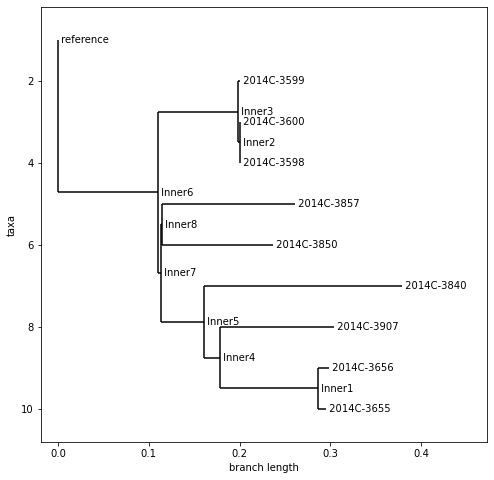

In [41]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator
import matplotlib.pyplot as plt

calculator = DistanceCalculator('identity')
constructor = DistanceTreeConstructor(calculator, 'nj')
tree = constructor.build_tree(alignment)
tree.root_with_outgroup('reference')
tree.ladderize()

plt.rcParams['figure.figsize'] = (8,8)
Bio.Phylo.draw(tree)